# Preprocessing

(in temperature dataset file, three question marks in data were deleted)

In [1]:
# unfortunately, the results are not reproducible even though many seeds were set

%set_env PYTHONHASHSEED=333
import keras
import random
random.seed(3)
from numpy.random import seed
seed(33)
from tensorflow import set_random_seed
set_random_seed(333)
keras_init = keras.initializers.glorot_uniform(seed=3333)

env: PYTHONHASHSEED=333


C:\Users\martin.smid\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<ul><li>
constants that can be varied to run different experiments
(thus results should be reproducible because of seed definition in random number generator)
</ul>

In [2]:
N_EPOCHS        = 100
N_NODES         = 10
N_LAST_FEATURES = 10              # i.e. window size (how many last days are used to predict the value)
N_BATCH_SIZE    = 10
N_DROPOUT       = 0.3

<ul><li>other constants</ul>

In [3]:
N_TRAIN_RATIO   = 0.8
N_VALID_RATIO   = 0.1             # therefore test portion = 1 - (0.8 + 0.1) = 0.1
N_NORMALIZE     = False           # => mse

log_file = 'results_temp.log'
with open(log_file, 'a') as myfile:
    myfile.write('N_EPOCHS=' + str(N_EPOCHS) + ' N_NODES=' + str(N_NODES) + ' N_LAST_FEATURES=' + str(N_LAST_FEATURES) +
                 ' N_BATCH_SIZE=' + str(N_BATCH_SIZE) + ' N_DROPOUT=' + str(N_DROPOUT) + '\n')

In [4]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

In [5]:
data_folder = '../datasets/'
temp_file   = data_folder + 'daily-minimum-temperatures-in-me.csv'
prec_file   = data_folder + 'monthly-precipitation-mm-philade.csv'

In [6]:
data_temp = pd.read_csv(temp_file, header=None)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
0    3650 non-null object
1    3650 non-null float64
dtypes: float64(1), object(1)
memory usage: 57.1+ KB


In [7]:
data_temp[1].describe()

count    3650.000000
mean       11.177753
std         4.071837
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: 1, dtype: float64

{'boxes': [<matplotlib.lines.Line2D at 0x1db3f21c0f0>],
 'caps': [<matplotlib.lines.Line2D at 0x1db3f21cb00>,
 'fliers': [<matplotlib.lines.Line2D at 0x1db3f22b7b8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1db3f22b390>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1db3f21c240>,
  <matplotlib.lines.Line2D at 0x1db3f21c6d8>]}

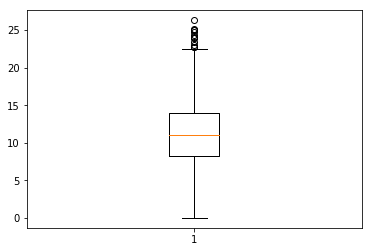

In [8]:
plt.boxplot(data_temp[1])

(array([ 53., 181., 564., 862., 830., 670., 347., 102.,  32.,   9.]),
 array([ 0.  ,  2.63,  5.26,  7.89, 10.52, 13.15, 15.78, 18.41, 21.04,
        23.67, 26.3 ]),
 <a list of 10 Patch objects>)

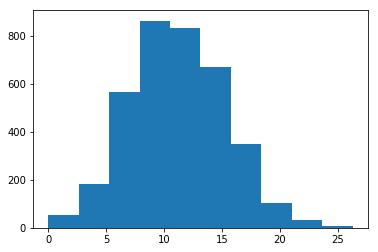

In [9]:
plt.hist(data_temp[1])

In [10]:
print('size:', data_temp.shape)
print('\n', data_temp.iloc[:3], sep='')

size: (3650, 2)

            0     1
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8


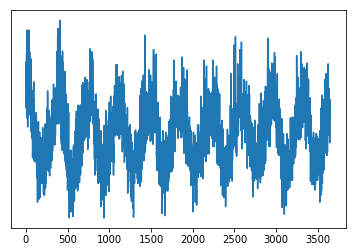

In [11]:
plt.plot(data_temp[1][::1])
plt.xticks()
plt.yticks([])
plt.show()

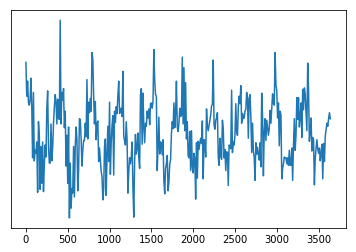

In [12]:
plt.plot(data_temp[1][::10])
plt.xticks()
plt.yticks([])
plt.show()

In [13]:
type(data_temp[1])

pandas.core.series.Series

In [14]:
def divisible(number, divisor):
    return int(divisor * round(number // divisor))

In [15]:
def preproc(orig_data, n_features):
    new = pd.DataFrame(orig_data)
    cols = []
    for i in range(n_features, 0, -1):
        cols.append(new.shift(i))
    cols.append(new.shift(0))
    joined = pd.concat(cols, axis=1)
    joined.dropna(inplace=True)
    return joined.values

In [16]:
# requires 2 columns, label second - indexing
def split_to_three(data):
    div_1 = int(        data[1].size * N_TRAIN_RATIO)          # index where to cut first
    div_2 = int(div_1 + data[1].size * N_VALID_RATIO)          # index where to cut second
    return data[:div_1].copy(), data[div_1:div_2].copy(), data[div_2:].copy()

<ul><li>first split to 3 subsets, then preprocess</ul>

In [17]:
# split
tr_d, va_d, te_d = split_to_three(data_temp)

# potentially apply minmax normalizing
from sklearn.preprocessing import MinMaxScaler
if N_NORMALIZE is True:
    values = tr_d[1].values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler()
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    #inversed = scaler.inverse_transform(normalized)
    tr_d[1] = normalized

    values = va_d[1].values
    values = values.reshape((len(values), 1))
    normalized = scaler.transform(values)
    va_d[1] = normalized

    values = te_d[1].values
    values = values.reshape((len(values), 1))
    normalized = scaler.transform(values)
    te_d[1] = normalized

# prepare
train_dataset = preproc(tr_d[1], N_LAST_FEATURES)
valid_dataset = preproc(va_d[1], N_LAST_FEATURES)
test_dataset  = preproc(te_d[1], N_LAST_FEATURES)

In [18]:
# checking sizes
print(tr_d[1].size)
print(train_dataset.size // tr_d[1].size)
print(va_d[1].size)
print(valid_dataset.size // va_d[1].size)

2920
10
365
10


In [19]:
# split input data and labels, for clarity
train_data = array([item[:-1].tolist() for item in train_dataset])
#train_data
train_labels = array([item[-1] for item in train_dataset])
#train_labels
valid_data   = array([item[:-1].tolist() for item in valid_dataset])
valid_labels = array([item[-1] for item in valid_dataset])
test_data   = array([item[:-1].tolist() for item in test_dataset])
test_labels = array([item[-1] for item in test_dataset])

In [20]:
# reshape for keras model fit function
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
valid_data = valid_data.reshape((valid_data.shape[0], valid_data.shape[1], 1))
test_data  = test_data.reshape( (test_data.shape[0],  test_data.shape[1], 1))

## Modeling

### CNN

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint

In [22]:
%%time

keras.backend.clear_session() # avoids errors by clearing TF graph, but throws away other models
set_random_seed(333)
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(N_LAST_FEATURES, 1), kernel_initializer=keras_init))
model_cnn.add(Dropout(N_DROPOUT, seed=3))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(N_NODES, activation='relu', kernel_initializer=keras_init))
model_cnn.add(Dense(1, kernel_initializer=keras_init))
# adam optimizer = gradient descent
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mse']) # the metrics parameter is superfluous, added for clarity
model_chckp = ModelCheckpoint(filepath='best_cnn.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_cnn.fit(train_data, train_labels, epochs=N_EPOCHS, validation_data=(valid_data, valid_labels), 
              batch_size=N_BATCH_SIZE, callbacks=[model_chckp], shuffle=False)
model_cnn.load_weights('best_cnn.hdf5')

Train on 2910 samples, validate on 355 samples
Epoch 1/100
2910/2910 [==============================] - 1s 240us/step - loss: 25.4890 - mean_squared_error: 25.4890 - val_loss: 11.9853 - val_mean_squared_error: 11.9853

Epoch 00001: val_loss improved from inf to 11.98534, saving model to best_cnn.hdf5
Epoch 2/100
2910/2910 [==============================] - 0s 129us/step - loss: 11.3692 - mean_squared_error: 11.3692 - val_loss: 10.9567 - val_mean_squared_error: 10.9567

Epoch 00002: val_loss improved from 11.98534 to 10.95665, saving model to best_cnn.hdf5
Epoch 3/100
2910/2910 [==============================] - 0s 124us/step - loss: 10.7447 - mean_squared_error: 10.7447 - val_loss: 10.3762 - val_mean_squared_error: 10.3762

Epoch 00003: val_loss improved from 10.95665 to 10.37618, saving model to best_cnn.hdf5
Epoch 4/100
2910/2910 [==============================] - 0s 121us/step - loss: 10.4913 - mean_squared_error: 10.4913 - val_loss: 10.5307 - val_mean_squared_error: 10.5307

Epoch 

2910/2910 [==============================] - 0s 116us/step - loss: 9.6547 - mean_squared_error: 9.6547 - val_loss: 15.4395 - val_mean_squared_error: 15.4395

Epoch 00037: val_loss did not improve from 10.37618
Epoch 38/100
2910/2910 [==============================] - 0s 126us/step - loss: 9.5547 - mean_squared_error: 9.5547 - val_loss: 15.1295 - val_mean_squared_error: 15.1295

Epoch 00038: val_loss did not improve from 10.37618
Epoch 39/100
2910/2910 [==============================] - 0s 122us/step - loss: 9.6840 - mean_squared_error: 9.6840 - val_loss: 15.3893 - val_mean_squared_error: 15.3893

Epoch 00039: val_loss did not improve from 10.37618
Epoch 40/100
2910/2910 [==============================] - 0s 124us/step - loss: 9.6141 - mean_squared_error: 9.6141 - val_loss: 15.2234 - val_mean_squared_error: 15.2234

Epoch 00040: val_loss did not improve from 10.37618
Epoch 41/100
2910/2910 [==============================] - 0s 120us/step - loss: 9.5934 - mean_squared_error: 9.5934 - val


Epoch 00073: val_loss did not improve from 10.37618
Epoch 74/100
2910/2910 [==============================] - 0s 123us/step - loss: 9.3026 - mean_squared_error: 9.3026 - val_loss: 14.3467 - val_mean_squared_error: 14.3467

Epoch 00074: val_loss did not improve from 10.37618
Epoch 75/100
2910/2910 [==============================] - 0s 116us/step - loss: 9.2873 - mean_squared_error: 9.2873 - val_loss: 14.2240 - val_mean_squared_error: 14.2240

Epoch 00075: val_loss did not improve from 10.37618
Epoch 76/100
2910/2910 [==============================] - 0s 120us/step - loss: 9.1883 - mean_squared_error: 9.1883 - val_loss: 14.2009 - val_mean_squared_error: 14.2009

Epoch 00076: val_loss did not improve from 10.37618
Epoch 77/100
2910/2910 [==============================] - 0s 120us/step - loss: 9.2921 - mean_squared_error: 9.2921 - val_loss: 14.2414 - val_mean_squared_error: 14.2414

Epoch 00077: val_loss did not improve from 10.37618
Epoch 78/100
2910/2910 [==============================]

In [23]:
# evaluate on unseen data
scores = model_cnn.evaluate(test_data, test_labels, batch_size=N_BATCH_SIZE, verbose=0)
print('Average MSE on test data:', scores[0])

Average MSE on test data: 9.954964945014094


In [24]:
# log results
with open(log_file, 'a') as myfile:
    myfile.write('CNN  ' + str(round(min(model_cnn.history.history['val_loss']), 2)) + ' ' + str(round(scores[0], 2)) + '\n')

In [25]:
# prediction example, on valid data
i = 7
pred_input  = test_dataset[i][:-1].reshape((1, N_LAST_FEATURES, 1))
pred_output = model_cnn.predict(pred_input, verbose=0)
print('Data:', test_data[i].tolist())
print('Prediction value:', pred_output[0][0])
print('Real value:      ', test_labels[i])

Data: [[14.8], [17.4], [18.8], [22.1], [19.0], [15.5], [15.8], [14.7], [10.7], [11.5]]
Prediction value: 12.716601
Real value:       15.0


<ul><li>"model quality" - loss on validation data during epochs: 0-20 and 20+</ul>

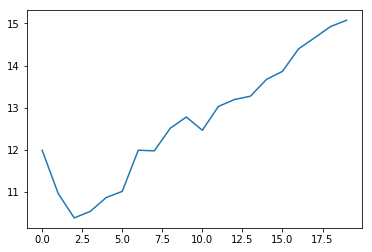

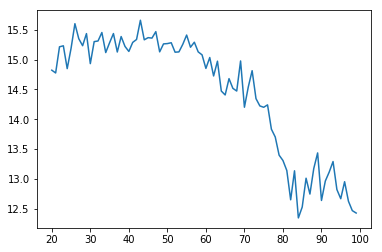

In [26]:
beg = 20
plt.plot(range(0, beg), model_cnn.history.history['val_loss'][:beg])
plt.show()
plt.plot(range(beg, len(model_cnn.history.history['val_loss'])), model_cnn.history.history['val_loss'][beg:])
plt.show()

### RNN

In [27]:
from keras.layers import SimpleRNN

In [28]:
%%time

# for RNN to work properly, input data must be divisible by batch_size
tds  = divisible(train_data.shape[0], N_BATCH_SIZE) # train data size
vds  = divisible(valid_data.shape[0], N_BATCH_SIZE) # validation data size
teds = divisible(test_data.shape[0],  N_BATCH_SIZE) # test data size

keras.backend.clear_session() # avoids errors by clearing TF graph, but throws away other models
set_random_seed(333)
model_rnn = Sequential()
model_rnn.add(SimpleRNN(N_NODES, activation='tanh', input_shape=(N_LAST_FEATURES, 1), batch_size=N_BATCH_SIZE, stateful=True, kernel_initializer=keras_init))
model_rnn.add(Dropout(N_DROPOUT, seed=3))
model_rnn.add(Dense(N_NODES, activation='relu', kernel_initializer=keras_init))
model_rnn.add(Dense(1, kernel_initializer=keras_init))
# adam optimizer = gradient descent
model_rnn.compile(optimizer='adam', loss='mse', metrics=['mse']) # the metrics parameter is superfluous, added for clarity
model_chckp = ModelCheckpoint(filepath='best_rnn.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_rnn.fit(train_data[:tds], train_labels[:tds], epochs=N_EPOCHS, validation_data=(valid_data[:vds], valid_labels[:vds]),
              batch_size=N_BATCH_SIZE, callbacks=[model_chckp],
              shuffle=False) # not shuffling - mandatory because of RNN)
model_rnn.load_weights('best_rnn.hdf5')

Train on 2910 samples, validate on 350 samples
Epoch 1/100
2910/2910 [==============================] - 1s 248us/step - loss: 92.7019 - mean_squared_error: 92.7019 - val_loss: 26.3493 - val_mean_squared_error: 26.3493

Epoch 00001: val_loss improved from inf to 26.34934, saving model to best_rnn.hdf5
Epoch 2/100
2910/2910 [==============================] - 0s 119us/step - loss: 20.9083 - mean_squared_error: 20.9083 - val_loss: 11.9252 - val_mean_squared_error: 11.9252

Epoch 00002: val_loss improved from 26.34934 to 11.92522, saving model to best_rnn.hdf5
Epoch 3/100
2910/2910 [==============================] - 0s 145us/step - loss: 14.6255 - mean_squared_error: 14.6255 - val_loss: 8.1150 - val_mean_squared_error: 8.1150

Epoch 00003: val_loss improved from 11.92522 to 8.11505, saving model to best_rnn.hdf5
Epoch 4/100
2910/2910 [==============================] - 0s 140us/step - loss: 12.9840 - mean_squared_error: 12.9840 - val_loss: 7.1761 - val_mean_squared_error: 7.1761

Epoch 00004

2910/2910 [==============================] - 0s 136us/step - loss: 7.4204 - mean_squared_error: 7.4204 - val_loss: 5.9038 - val_mean_squared_error: 5.9038

Epoch 00036: val_loss did not improve from 5.53028
Epoch 37/100
2910/2910 [==============================] - 0s 141us/step - loss: 7.3371 - mean_squared_error: 7.3371 - val_loss: 5.6559 - val_mean_squared_error: 5.6559

Epoch 00037: val_loss did not improve from 5.53028
Epoch 38/100
2910/2910 [==============================] - 0s 135us/step - loss: 7.3206 - mean_squared_error: 7.3206 - val_loss: 5.7959 - val_mean_squared_error: 5.7959

Epoch 00038: val_loss did not improve from 5.53028
Epoch 39/100
2910/2910 [==============================] - 0s 129us/step - loss: 7.4100 - mean_squared_error: 7.4100 - val_loss: 5.8111 - val_mean_squared_error: 5.8111

Epoch 00039: val_loss did not improve from 5.53028
Epoch 40/100
2910/2910 [==============================] - 0s 153us/step - loss: 7.2718 - mean_squared_error: 7.2718 - val_loss: 5.503

2910/2910 [==============================] - 0s 142us/step - loss: 7.0924 - mean_squared_error: 7.0924 - val_loss: 5.6609 - val_mean_squared_error: 5.6609

Epoch 00073: val_loss did not improve from 5.28532
Epoch 74/100
2910/2910 [==============================] - 0s 124us/step - loss: 6.9480 - mean_squared_error: 6.9480 - val_loss: 5.6445 - val_mean_squared_error: 5.6445

Epoch 00074: val_loss did not improve from 5.28532
Epoch 75/100
2910/2910 [==============================] - 0s 133us/step - loss: 7.1174 - mean_squared_error: 7.1174 - val_loss: 5.2151 - val_mean_squared_error: 5.2151

Epoch 00075: val_loss improved from 5.28532 to 5.21508, saving model to best_rnn.hdf5
Epoch 76/100
2910/2910 [==============================] - 0s 124us/step - loss: 7.0102 - mean_squared_error: 7.0102 - val_loss: 5.1832 - val_mean_squared_error: 5.1832

Epoch 00076: val_loss improved from 5.21508 to 5.18320, saving model to best_rnn.hdf5
Epoch 77/100
2910/2910 [==============================] - 0s 13

In [29]:
scores = model_rnn.evaluate(test_data[:teds], test_labels[:teds], batch_size=N_BATCH_SIZE, verbose=0)
print('Average MSE on test data:', scores[0])

Average MSE on test data: 5.3644121289253235


In [30]:
# log results
with open(log_file, 'a') as myfile:
    myfile.write('RNN  ' + str(round(min(model_rnn.history.history['val_loss']), 2)) + ' ' + str(round(scores[0], 2)) + '\n')

<ul><li>"model quality" - loss on validation data during epochs: 0-20 and 20+</ul>

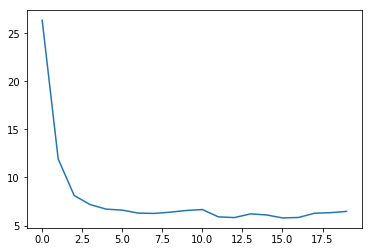

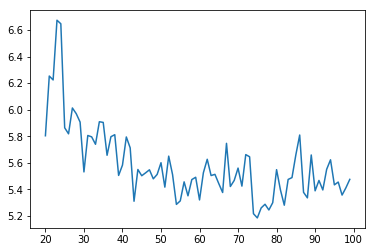

In [31]:
beg = 20
plt.plot(range(0, beg), model_rnn.history.history['val_loss'][:beg])
plt.show()
plt.plot(range(beg, len(model_rnn.history.history['val_loss'])), model_rnn.history.history['val_loss'][beg:])
plt.show()

### LSTM

In [32]:
from keras.layers import LSTM

In [33]:
%%time

# for RNN to work properly, input data must be divisible by batch_size
tds  = divisible(train_data.shape[0], N_BATCH_SIZE) # train data size
vds  = divisible(valid_data.shape[0], N_BATCH_SIZE) # validation data size
teds = divisible(test_data.shape[0],  N_BATCH_SIZE) # test data size

keras.backend.clear_session() # avoids errors by clearing TF graph, but throws away other models
set_random_seed(333)
model_lstm = Sequential()
model_lstm.add(LSTM(N_NODES, activation='tanh', input_shape=(N_LAST_FEATURES, 1), batch_size=N_BATCH_SIZE, stateful=True, kernel_initializer=keras_init))
model_lstm.add(Dropout(N_DROPOUT, seed=3))
model_lstm.add(Dense(N_NODES, activation='relu', kernel_initializer=keras_init))
model_lstm.add(Dense(1, kernel_initializer=keras_init))
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mse']) # the metrics parameter is superfluous, added for clarity
model_chckp = ModelCheckpoint(filepath='best_lstm.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_lstm.fit(train_data[:tds], train_labels[:tds], epochs=N_EPOCHS, 
               validation_data=(valid_data[:vds], valid_labels[:vds]), 
               batch_size=N_BATCH_SIZE, shuffle=False, 
               callbacks=[model_chckp]) # not shuffling - mandatory because of RNN
model_lstm.load_weights('best_lstm.hdf5')

Train on 2910 samples, validate on 350 samples
Epoch 1/100
2910/2910 [==============================] - 1s 451us/step - loss: 72.4701 - mean_squared_error: 72.4701 - val_loss: 19.7836 - val_mean_squared_error: 19.7836

Epoch 00001: val_loss improved from inf to 19.78361, saving model to best_lstm.hdf5
Epoch 2/100
2910/2910 [==============================] - 1s 235us/step - loss: 18.8554 - mean_squared_error: 18.8554 - val_loss: 9.5025 - val_mean_squared_error: 9.5025

Epoch 00002: val_loss improved from 19.78361 to 9.50247, saving model to best_lstm.hdf5
Epoch 3/100
2910/2910 [==============================] - 1s 242us/step - loss: 14.3244 - mean_squared_error: 14.3244 - val_loss: 7.0781 - val_mean_squared_error: 7.0781

Epoch 00003: val_loss improved from 9.50247 to 7.07812, saving model to best_lstm.hdf5
Epoch 4/100
2910/2910 [==============================] - 1s 248us/step - loss: 12.8772 - mean_squared_error: 12.8772 - val_loss: 6.4592 - val_mean_squared_error: 6.4592

Epoch 00004:


Epoch 00035: val_loss did not improve from 5.03136
Epoch 36/100
2910/2910 [==============================] - 1s 276us/step - loss: 6.8356 - mean_squared_error: 6.8356 - val_loss: 5.2289 - val_mean_squared_error: 5.2289

Epoch 00036: val_loss did not improve from 5.03136
Epoch 37/100
2910/2910 [==============================] - 1s 256us/step - loss: 6.7309 - mean_squared_error: 6.7309 - val_loss: 5.2474 - val_mean_squared_error: 5.2474

Epoch 00037: val_loss did not improve from 5.03136
Epoch 38/100
2910/2910 [==============================] - 1s 248us/step - loss: 6.7523 - mean_squared_error: 6.7523 - val_loss: 5.3369 - val_mean_squared_error: 5.3369

Epoch 00038: val_loss did not improve from 5.03136
Epoch 39/100
2910/2910 [==============================] - 1s 238us/step - loss: 6.8565 - mean_squared_error: 6.8565 - val_loss: 5.1624 - val_mean_squared_error: 5.1624

Epoch 00039: val_loss did not improve from 5.03136
Epoch 40/100
2910/2910 [==============================] - 1s 231us/s

2910/2910 [==============================] - 1s 229us/step - loss: 6.4168 - mean_squared_error: 6.4168 - val_loss: 5.3500 - val_mean_squared_error: 5.3500

Epoch 00073: val_loss did not improve from 5.03136
Epoch 74/100
2910/2910 [==============================] - 1s 247us/step - loss: 6.4195 - mean_squared_error: 6.4195 - val_loss: 5.4399 - val_mean_squared_error: 5.4399

Epoch 00074: val_loss did not improve from 5.03136
Epoch 75/100
2910/2910 [==============================] - 1s 234us/step - loss: 6.5203 - mean_squared_error: 6.5203 - val_loss: 5.2900 - val_mean_squared_error: 5.2900

Epoch 00075: val_loss did not improve from 5.03136
Epoch 76/100
2910/2910 [==============================] - 1s 241us/step - loss: 6.3974 - mean_squared_error: 6.3974 - val_loss: 5.3681 - val_mean_squared_error: 5.3681

Epoch 00076: val_loss did not improve from 5.03136
Epoch 77/100
2910/2910 [==============================] - 1s 241us/step - loss: 6.4137 - mean_squared_error: 6.4137 - val_loss: 5.416

In [34]:
scores = model_lstm.evaluate(test_data[:teds], test_labels[:teds], batch_size=N_BATCH_SIZE, verbose=0)
print('Average MSE on test data:', scores[0])

Average MSE on test data: 5.313957350594657


In [35]:
# log results
with open(log_file, 'a') as myfile:
    myfile.write('LSTM ' + str(round(min(model_lstm.history.history['val_loss']), 2)) + ' ' + str(round(scores[0], 2)) + '\n\n')

<ul><li>"model quality" - loss on validation data during epochs: 0-20 and 20+</ul>

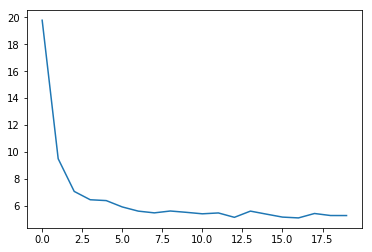

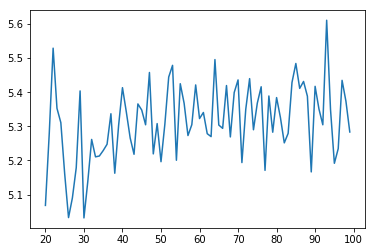

In [36]:
beg = 20
plt.plot(range(0, beg), model_lstm.history.history['val_loss'][:beg])
plt.show()
plt.plot(range(beg, len(model_lstm.history.history['val_loss'])), model_lstm.history.history['val_loss'][beg:])
plt.show()

In [37]:
keras.backend.clear_session() # clears tf environment after run